In [3]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
import numpy as np
import itertools
import os
import matplotlib.pyplot as plt
from time import time, ctime
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold,\
cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

from helper import plot_confusion_matrix, plot_confusion_matrix2
dim=lambda *x: [i.shape for i in x]

In [5]:
%%time
df=pd.read_csv('./goden_before_encode3.csv')
print df.shape

(44812, 851)
CPU times: user 2.97 s, sys: 205 ms, total: 3.17 s
Wall time: 3.2 s


In [6]:
df.head(2)

,username,about.chosen_role,about.company,about.hourly_rate,about.primary_language,about.recommendations,about.registration_date,about.role,about.tagline,hourlyRate,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,3.0,Innovate it,500,id,0.0,1.076001e+09,1.0,97,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0
1,ArmenSoft,0.0,0,0,0,0.0,0.000000e+00,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,5.0,9.0


In [7]:
y=df.pop('fname.gender').map({'male':1, 'female':0}).values
len(y)

44812

In [8]:
df.head(1)

,username,about.chosen_role,about.company,about.hourly_rate,about.primary_language,about.recommendations,about.registration_date,about.role,about.tagline,hourlyRate,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,billion,3.0,Innovate it,500,id,0.0,1.076001e+09,1.0,97,500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [9]:
X=df.iloc[:, 1:]

### labelencoding

In [10]:
feature_df = df.iloc[0:1, 1:]

In [11]:
feature_df

,about.chosen_role,about.company,about.hourly_rate,about.primary_language,about.recommendations,about.registration_date,about.role,about.tagline,hourlyRate,resume.show,...,feature_721,feature_722,feature_723,feature_724,feature_725,feature_726,feature_727,feature_728,feature_729,feature_730
0,3.0,Innovate it,500,id,0.0,1.076001e+09,1.0,97,500.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,14.0,7.0


In [12]:
feature_df.select_dtypes(include=['O']).shape

(1, 31)

### batch label encoding string variables and collect the encoders into a dictionary

In [13]:
%%time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

Labels={}

for i in X.select_dtypes(include=['O']).columns:
    exec("labelencoder_{} = LabelEncoder()".format(i.replace('.','_')))
    exec("X['{}'] = labelencoder_{}.fit_transform(X['{}'])".format(i,i.replace('.','_'),i))
    exec("Labels['labelencoder_{}']=labelencoder_{}".format(i.replace('.','_'), i.replace('.','_')))

print len(Labels)

31
CPU times: user 841 ms, sys: 0 ns, total: 841 ms
Wall time: 838 ms


In [14]:
Labels

{'labelencoder_about_company': LabelEncoder(),
 'labelencoder_about_primary_language': LabelEncoder(),
 'labelencoder_city_3': LabelEncoder(),
 'labelencoder_code_2': LabelEncoder(),
 'labelencoder_country_2': LabelEncoder(),
 'labelencoder_country_5': LabelEncoder(),
 'labelencoder_country_code_3': LabelEncoder(),
 'labelencoder_country_flag_class_3': LabelEncoder(),
 'labelencoder_country_name_3': LabelEncoder(),
 'labelencoder_deposit_made': LabelEncoder(),
 'labelencoder_email_verified': LabelEncoder(),
 'labelencoder_facebook_connected': LabelEncoder(),
 'labelencoder_first': LabelEncoder(),
 'labelencoder_first2': LabelEncoder(),
 'labelencoder_first3': LabelEncoder(),
 'labelencoder_identity_verified': LabelEncoder(),
 'labelencoder_last': LabelEncoder(),
 'labelencoder_last2': LabelEncoder(),
 'labelencoder_last3': LabelEncoder(),
 'labelencoder_name_2': LabelEncoder(),
 'labelencoder_payment_verified': LabelEncoder(),
 'labelencoder_phone_verified': LabelEncoder(),
 'labelenco

In [15]:
X.shape, y.shape

((44812, 849), (44812,))

In [24]:
# helper functions
def impliment(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print accuracy_score(y_test, pred)
    plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])
    return model

def plotting(model, df, num):
    forest = model
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="g", xerr=std[indices][:num], 
            align="center", alpha=.7)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(num):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))
        
def plotting2(model, df, num):
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]



    # Plot the feature importances of the forest
    plt.figure(figsize=(16,8))
    plt.title("Feature importances")
    plt.barh(range(num), importances[indices][:num],
           color="r", 
            align="center", alpha=.6)

    plt.yticks(range(num), list(df.columns[indices][:num],))
    plt.ylim([-1, num])

    plt.gca().invert_yaxis()

    plt.show()

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(num):
        print("{}. feature {} ({:.2f} %)" .format (f + 1, df.columns[indices[f]], 100*importances[indices[f]]))

In [16]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X=sc.fit_transform(X)
print X.shape, type(X)

(44812, 849) <type 'numpy.ndarray'>
CPU times: user 3.08 s, sys: 644 ms, total: 3.72 s
Wall time: 3.72 s


### initial RandomForest model, before onehot encoding and nomalizing

In [15]:
%%time
print cross_val_score(RandomForestClassifier(n_estimators=160, min_samples_split=3, n_jobs=24), X, y, cv=10)

[ 0.82195448  0.82329317  0.82552432  0.82307006  0.82526222  0.82503905
  0.82704753  0.82615488  0.82611607  0.40848214]
CPU times: user 10min 50s, sys: 3.95 s, total: 10min 54s
Wall time: 50.1 s


### train test split on 7:3

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(31368, 849), (13444, 849), (31368,), (13444,)]

0.82282058911
Confusion matrix, without normalization
[[  103  2347]
 [   35 10959]]


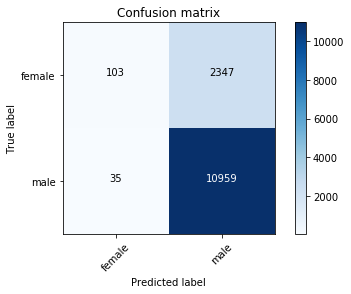

CPU times: user 26.8 s, sys: 1.66 s, total: 28.5 s
Wall time: 3.42 s


In [18]:
%%time
model1 = impliment(RandomForestClassifier(n_estimators=80, min_samples_split=2, n_jobs=24))

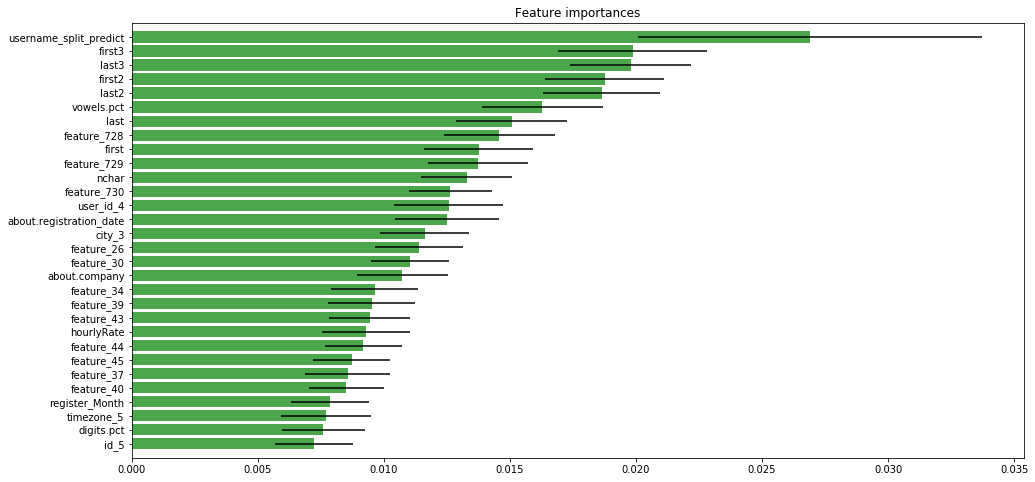

Feature ranking:
1. feature username_split_predict (2.69 %)
2. feature first3 (1.99 %)
3. feature last3 (1.98 %)
4. feature first2 (1.88 %)
5. feature last2 (1.86 %)
6. feature vowels.pct (1.63 %)
7. feature last (1.51 %)
8. feature feature_728 (1.46 %)
9. feature first (1.38 %)
10. feature feature_729 (1.37 %)
11. feature nchar (1.33 %)
12. feature feature_730 (1.26 %)
13. feature user_id_4 (1.26 %)
14. feature about.registration_date (1.25 %)
15. feature city_3 (1.16 %)
16. feature feature_26 (1.14 %)
17. feature feature_30 (1.10 %)
18. feature about.company (1.07 %)
19. feature feature_34 (0.96 %)
20. feature feature_39 (0.95 %)
21. feature feature_43 (0.94 %)
22. feature hourlyRate (0.93 %)
23. feature feature_44 (0.92 %)
24. feature feature_45 (0.87 %)
25. feature feature_37 (0.86 %)
26. feature feature_40 (0.85 %)
27. feature register_Month (0.79 %)
28. feature timezone_5 (0.77 %)
29. feature digits.pct (0.76 %)
30. feature id_5 (0.72 %)


In [19]:
plotting(model1, X, 30)

0.828994346921
Confusion matrix, without normalization
[[  316  2134]
 [  165 10829]]


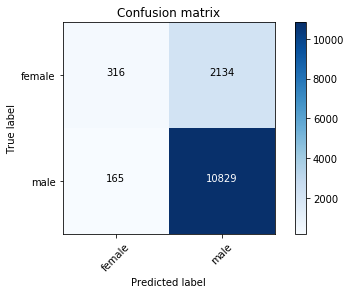

CPU times: user 24min 31s, sys: 1.71 s, total: 24min 33s
Wall time: 1min 6s


In [20]:
%%time
model2 = impliment(XGBClassifier(nthread=-1, max_depth=128,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6))

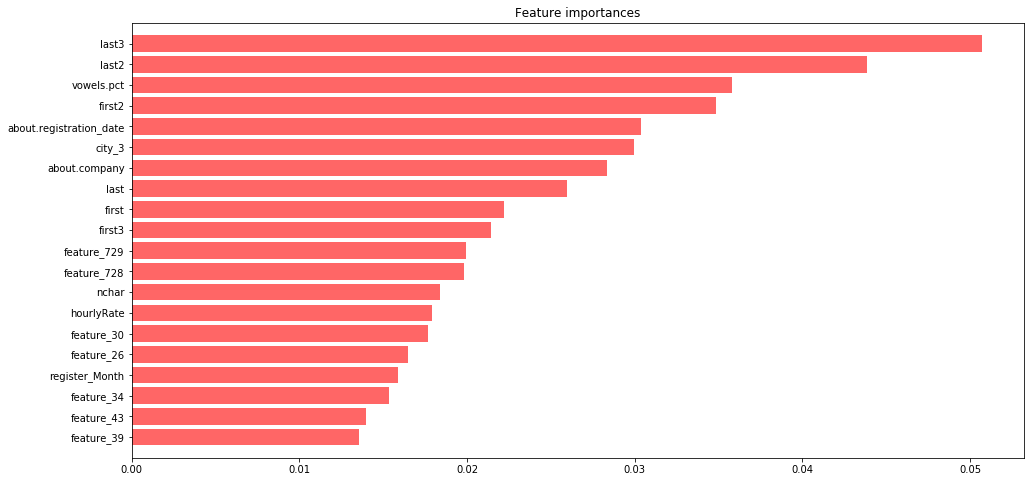

Feature ranking:
1. feature last3 (5.07 %)
2. feature last2 (4.39 %)
3. feature vowels.pct (3.58 %)
4. feature first2 (3.48 %)
5. feature about.registration_date (3.04 %)
6. feature city_3 (2.99 %)
7. feature about.company (2.84 %)
8. feature last (2.59 %)
9. feature first (2.22 %)
10. feature first3 (2.14 %)
11. feature feature_729 (2.00 %)
12. feature feature_728 (1.98 %)
13. feature nchar (1.84 %)
14. feature hourlyRate (1.79 %)
15. feature feature_30 (1.77 %)
16. feature feature_26 (1.65 %)
17. feature register_Month (1.59 %)
18. feature feature_34 (1.53 %)
19. feature feature_43 (1.40 %)
20. feature feature_39 (1.36 %)


In [25]:
plotting2(model2, X, 20)

## Onehot encoding, nomalizing, feature selection

#### string fields

In [26]:
string_col_index = feature_df.columns.get_indexer(feature_df.select_dtypes(include=['O']).columns)
string_col_index

array([  1,   3,   9,  11,  20,  21,  22,  23,  24,  25,  28,  29,  82,
        85,  86,  90,  91,  92,  93,  94,  95,  96,  97, 100, 101, 102,
       103, 104, 105, 106, 107])

In [27]:
X.shape

(44812, 849)

In [28]:
onehot = OneHotEncoder(categorical_features = string_col_index)
onehot

OneHotEncoder(categorical_features=array([  1,   3,   9,  11,  20,  21,  22,  23,  24,  25,  28,  29,  82,
        85,  86,  90,  91,  92,  93,  94,  95,  96,  97, 100, 101, 102,
       103, 104, 105, 106, 107]),
       dtype=<type 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)

In [29]:
XX=X.copy()

In [30]:
XX.iloc[:3, string_col_index]

,about.company,about.primary_language,resume.show,register_Month,city_3,country_code_3,country_flag_class_3,country_name_3,code_2,country_2,...,profile_complete,country_5,timezone_5,username_split_predict,last,last2,last3,first,first2,first3
0,7694,10,1,4,4403,144,149,151,21,21,...,2,144,234,2,49,1379,5364,1,974,4167
1,25,0,0,0,9,0,0,0,0,0,...,0,0,0,1,55,1004,7441,0,43,220
2,16437,6,2,4,4308,162,162,164,21,21,...,2,166,60,1,49,788,6442,14,1405,8289


#### unique nums of each string fields

In [31]:
XX.iloc[:, string_col_index].apply(pd.Series.nunique)

about.company                22447
about.primary_language          24
resume.show                      3
register_Month                  13
city_3                        8932
country_code_3                 175
country_flag_class_3           174
country_name_3                 175
code_2                          24
country_2                       24
name_2                          24
sign_2                          15
summary_completion_rate_4       91
summary_on_budget_4             26
summary_on_time_4               47
deposit_made                     3
email_verified                   3
facebook_connected               3
identity_verified                3
payment_verified                 3
phone_verified                   3
profile_complete                 3
country_5                      181
timezone_5                     267
username_split_predict           3
last                            62
last2                         1801
last3                        10608
first               

#### sum of additional columns could be added after onehot encoding

In [32]:
XX.iloc[:, string_col_index].apply(pd.Series.nunique).sum()

57688L

### one hot encoding

In [33]:
%%time
XX = onehot.fit_transform(XX)

CPU times: user 2.27 s, sys: 384 ms, total: 2.65 s
Wall time: 2.65 s


In [34]:
XX

<44812x58506 sparse matrix of type '<type 'numpy.float64'>'
	with 3120301 stored elements in COOrdinate format>

In [35]:
# %%time
# X=X.toarray()

In [36]:
XX, type(X)

(<44812x58506 sparse matrix of type '<type 'numpy.float64'>'
 	with 3120301 stored elements in COOrdinate format>,
 pandas.core.frame.DataFrame)

### nomalizing

In [37]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
XX=sc.fit_transform(XX)
print XX.shape, type(XX)

(44812, 58506) <class 'scipy.sparse.csr.csr_matrix'>
CPU times: user 905 ms, sys: 13 ms, total: 918 ms
Wall time: 916 ms


In [38]:
%%time
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X=sc.fit_transform(X)
print X.shape, type(X)

(44812, 849) <type 'numpy.ndarray'>
CPU times: user 3.13 s, sys: 472 ms, total: 3.61 s
Wall time: 3.6 s


In [39]:
%%time
print cross_val_score(RandomForestClassifier(n_estimators=160, min_samples_split=3, n_jobs=24), XX, y, cv=10)

[ 0.82195448  0.82284694  0.82418563  0.8221776   0.82325374  0.82280741
  0.82370007  0.82146842  0.821875    0.64040179]
CPU times: user 38min 50s, sys: 2.22 s, total: 38min 52s
Wall time: 1min 49s


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(31368, 58506), (13444, 58506), (31368,), (13444,)]

0.821630467123
Confusion matrix, without normalization
[[   76  2374]
 [   24 10970]]


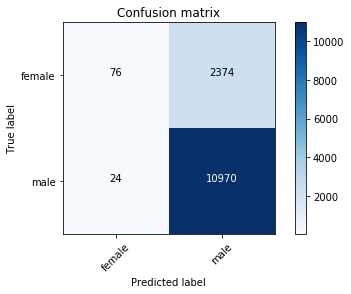

CPU times: user 36 s, sys: 152 ms, total: 36.1 s
Wall time: 2.93 s


In [41]:
%%time
model_b1 = impliment(RandomForestClassifier(n_estimators=30, min_samples_split=2, n_jobs=24))

0.827878607557
Confusion matrix, without normalization
[[  323  2127]
 [  187 10807]]


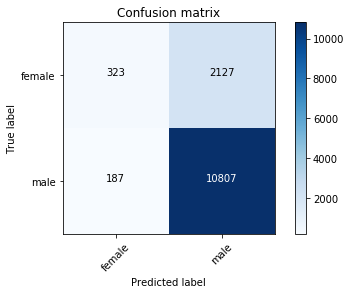

CPU times: user 6min 24s, sys: 612 ms, total: 6min 24s
Wall time: 19.4 s


In [42]:
%%time
model_b2 = impliment(XGBClassifier(nthread=-1, max_depth=64,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6))

### feature selection

#### stacking using only label encoded data 

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(31368, 849), (13444, 849), (31368,), (13444,)]

In [44]:
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.feature_selection import ColumnSelector
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier,\
ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

In [45]:
%%time
m1 = AdaBoostClassifier().fit(X_train, y_train)
index1= pd.Series(m1.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/10*9].index

m2 = RandomForestClassifier(random_state=1, n_estimators=80, min_samples_split=2, n_jobs=-1).fit(X_train, y_train)
index2= pd.Series(m2.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/10*9].index

m3 = XGBClassifier(nthread=-1, max_depth=128, min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6).fit(X_train, y_train)
index3= pd.Series(m3.feature_importances_).sort_values(ascending=False)[:X_train.shape[1]/10*9].index

CPU times: user 28min 28s, sys: 1.15 s, total: 28min 30s
Wall time: 1min 41s


### stacking

In [ ]:
%%time

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier(random_state=1, n_estimators=80, min_samples_split=2, n_jobs=-1)
clf3 = XGBClassifier(nthread=-1, max_depth=128,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6)
clf4 = BaggingClassifier(n_jobs=-1, n_estimators=50)
clf5 = ExtraTreesClassifier(n_jobs=-1, bootstrap=True, n_estimators=100)
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)

pipe1 = make_pipeline(ColumnSelector(cols=index1), clf1)
pipe2 = make_pipeline(ColumnSelector(cols=index2), clf2)
pipe3 = make_pipeline(ColumnSelector(cols=index3), clf3)

sclf = StackingCVClassifier(classifiers=[ pipe1, pipe2, pipe3, clf4, clf5], 
                          meta_classifier=lr,
                          use_probas=True )



print('5-fold cross validation:\n')

if __name__ == '__main__':
    
    stack3 = []
    for clf, label in zip([ pipe1, pipe2, pipe3, clf4, clf5,  sclf], 
                          [ 'AdaBoost', 
                           'Random Forest',
                           'Xgboost',
                           'Bagging',
                           'ExtraTrees',
                           'Stacking']):

        scores = model_selection.cross_val_score(clf, X.values, y, 
#                                                  n_jobs=-1,
                                                  cv=5, scoring='accuracy')
        stack3.append([label, scores, scores.mean(), scores.std()])
        print("Accuracy: %0.4f (+/- %0.4f) [%s]" 
              % (scores.mean(), scores.std(), label))

In [47]:
# stack3

In [49]:
%%time

RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

clf1 = AdaBoostClassifier()
clf2 = RandomForestClassifier(random_state=1, n_estimators=120, min_samples_split=2, n_jobs=-1)
clf3 = XGBClassifier(nthread=-1, max_depth=96,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6)
clf4 = BaggingClassifier(n_jobs=-1, n_estimators=50)
clf5 = ExtraTreesClassifier(n_jobs=-1, bootstrap=True, n_estimators=100)
lr = LogisticRegression(solver='lbfgs', n_jobs=-1)

pipe1 = make_pipeline(ColumnSelector(cols=index1),
                      clf1)
pipe2 = make_pipeline(ColumnSelector(cols=index2),
                      clf2)
pipe3 = make_pipeline(ColumnSelector(cols=index3),
                      clf3)


sclf = StackingCVClassifier(classifiers=[pipe1, pipe2, pipe3, clf4, clf5], 
                          meta_classifier=lr,
                          use_probas=True )

if __name__ == '__main__':
    sclf.fit(X_train, y_train)

CPU times: user 30min 55s, sys: 6.22 s, total: 31min 1s
Wall time: 2min 54s


In [50]:
%%time
pred = sclf.predict(X_test)
print pred

[1 1 1 ..., 1 1 1]
CPU times: user 6.36 s, sys: 901 ms, total: 7.26 s
Wall time: 6.15 s


In [51]:
accuracy_score(y_test, pred)

0.83085391252603391

Confusion matrix, without normalization
[[  290  2160]
 [  114 10880]]


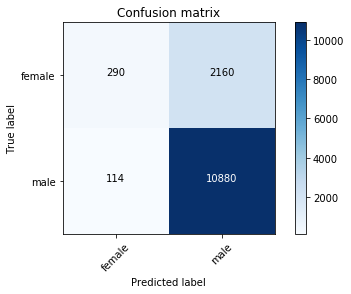

In [52]:
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=['female','male'])

In [53]:
%%time
pred_prob = sclf.predict_proba(X_test)
print pred_prob

[[ 0.19262317  0.80737683]
 [ 0.40222425  0.59777575]
 [ 0.15507998  0.84492002]
 ..., 
 [ 0.10709083  0.89290917]
 [ 0.17743159  0.82256841]
 [ 0.14111988  0.85888012]]
CPU times: user 6.81 s, sys: 1.38 s, total: 8.19 s
Wall time: 6.53 s


### maybe balancing trainning data can be of help, yet not guaranteed

http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [56]:
StackingClassifier.__bases__

(sklearn.base.BaseEstimator,
 sklearn.base.ClassifierMixin,
 sklearn.base.TransformerMixin)

In [68]:
getattr(StackingClassifier, 'fit', 'Fuck')

<unbound method StackingClassifier.fit>

In [69]:
getattr(StackingClassifier, 'what', 'Fuck')

'Fuck'

In [70]:
setattr?

https://www.python-course.eu/sys_module.php

### oversample

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                   random_state=7)
dim(X_train, X_test, y_train, y_test)

[(31368, 849), (13444, 849), (31368,), (13444,)]

In [19]:
from imblearn.over_sampling import RandomOverSampler

In [20]:
ros = RandomOverSampler(random_state=0)

In [21]:
%%time
X_train, y_train = ros.fit_sample(X_train, y_train)

CPU times: user 100 ms, sys: 62 ms, total: 162 ms
Wall time: 161 ms


In [22]:
pd.Series(y_train).value_counts()

1    25800
0    25800
dtype: int64

In [26]:
X_test.shape

(13444, 849)

0.822448675989
Confusion matrix, without normalization
[[  442  2008]
 [  379 10615]]


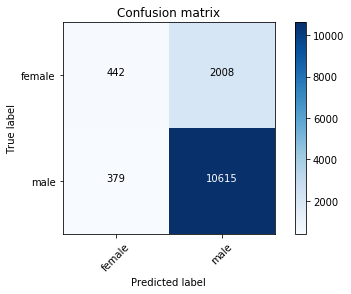

CPU times: user 48min 19s, sys: 3.54 s, total: 48min 23s
Wall time: 2min 7s


In [27]:
%%time
model2 = impliment(XGBClassifier(nthread=-1, max_depth=512,
                        min_child_weight=0.9, colsample_bytree=0.9,
                       scale_pos_weight= 0.9, reg_alpha=0.6))

0.823266884856
Confusion matrix, without normalization
[[  257  2193]
 [  183 10811]]


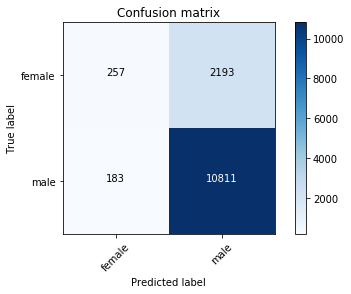

CPU times: user 23.1 s, sys: 241 ms, total: 23.3 s
Wall time: 1.57 s


In [29]:
%%time                                                                                                                                                                              
model2 = impliment(RandomForestClassifier(n_estimators=64, min_samples_split=2, n_jobs=24))